<table align="left">
  <td>
    <a href="https://colab.research.google.com/drive/1SQoK_O9pdMKqV_x340K2PgPPjWvaGbp8#scrollTo=qPgn0wihYUiR" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>

</table>

In [2]:
"""
Google Colab Setup Cell
Add this at the beginning of your notebook
"""

# ============================================
# GOOGLE COLAB SETUP
# ============================================

# 1. Check GPU availability
import torch
print("\n" + "="*50)
print("GPU INFORMATION")
print("="*50)
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ WARNING: No GPU detected. Training will be slow.")
    print("Enable GPU: Runtime → Change runtime type → Hardware accelerator → GPU")

# 2. Create directory structure
print("\n" + "="*50)
print("CREATING DIRECTORIES")
print("="*50)

import os

directories = [
    '/content/notebooks',
    '/content/reports',
    '/content/output',
    '/content/checkpoints',
    '/content/logs'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    print(f"✓ Created: {directory}")

# 3. Install required packages
print("\n" + "="*50)
print("INSTALLING PACKAGES")
print("="*50)
print("This may take 1-2 minutes...\n")

!pip install -q transformers datasets torch accelerate tensorboard scikit-learn
!pip install -U bitsandbytes accelerate peft transformers


print("✓ All packages installed successfully!")

# 4. Verify installations
print("\n" + "="*50)
print("VERIFYING INSTALLATIONS")
print("="*50)

import transformers
import datasets
import sklearn

print(f"✓ Transformers version: {transformers.__version__}")
print(f"✓ Datasets version: {datasets.__version__}")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ Scikit-learn version: {sklearn.__version__}")

# 5. Mount Google Drive (optional)
print("\n" + "="*50)
print("GOOGLE DRIVE MOUNT (OPTIONAL)")
print("="*50)

mount_drive = True  # Set to True to mount Google Drive

if mount_drive:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Google Drive mounted at /content/drive")
    print("  You can save models to /content/drive/MyDrive/")

    PROJECT_ROOT = '/content/drive/MyDrive/task3_xsum'

    REPORTS_DIR = f'{PROJECT_ROOT}/reports'
    OUTPUT_DIR = '/content/output'              # fast temp storage
    CHECKPOINT_DIR = f'{PROJECT_ROOT}/checkpoints'

    import os
    os.makedirs(REPORTS_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
else:
    print("Google Drive not mounted (set mount_drive=True to enable)")

print("\n" + "="*50)
print("SETUP COMPLETE! 🚀")
print("="*50)
print("\nYou can now proceed with the training notebook.")
print("All outputs will be saved to /content/ directories.")


GPU INFORMATION
GPU Available: True
GPU Device: NVIDIA A100-SXM4-80GB
GPU Memory: 85.17 GB

CREATING DIRECTORIES
✓ Created: /content/notebooks
✓ Created: /content/reports
✓ Created: /content/output
✓ Created: /content/checkpoints
✓ Created: /content/logs

INSTALLING PACKAGES
This may take 1-2 minutes...

✓ All packages installed successfully!

VERIFYING INSTALLATIONS
✓ Transformers version: 4.57.3
✓ Datasets version: 4.0.0
✓ PyTorch version: 2.9.0+cu126
✓ Scikit-learn version: 1.6.1

GOOGLE DRIVE MOUNT (OPTIONAL)
Mounted at /content/drive
✓ Google Drive mounted at /content/drive
  You can save models to /content/drive/MyDrive/

SETUP COMPLETE! 🚀

You can now proceed with the training notebook.
All outputs will be saved to /content/ directories.


In [3]:
# Fine-tuning Phi-2 for Text Summarization on XSum - Complete Colab Notebook

## 1. Setup and Installation
# Install packages - Phi-2 requires specific versions
!pip install -q transformers>=4.35.0 datasets torch accelerate bitsandbytes einops
!pip install -q evaluate rouge_score tensorboard peft

# Check GPU - Phi-2 needs good GPU!
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print("\n⚠️ Phi-2 requires 16GB+ GPU. Colab Free T4 has 15GB - may need Pro for A100")
else:
    print("❌ No GPU! This will NOT work without GPU.")

# Imports
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    TrainingArguments, Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import evaluate
from tqdm.auto import tqdm

# Create directories
for d in ['/content/notebooks', '/content/reports', '/content/checkpoints', '/content/logs']:
    os.makedirs(d, exist_ok=True)

# Set seed
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
set_seed(42)

print("Setup complete!")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00
GPU Available: True
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.17 GB

⚠️ Phi-2 requires 16GB+ GPU. Colab Free T4 has 15GB - may need Pro for A100
Setup complete!


In [4]:
# Set seed
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
set_seed(42)

print("Setup complete!")


Setup complete!


In [5]:
## 2. Load XSum Dataset
# Load XSum - extreme summarization dataset
from huggingface_hub import hf_hub_download
import tarfile, os

path = hf_hub_download(
    repo_id="xsum",
    repo_type="dataset",
    filename="data/XSUM-EMNLP18-Summary-Data-Original.tar.gz"
)

extract_dir = "/content/xsum_raw"
os.makedirs(extract_dir, exist_ok=True)

with tarfile.open(path, "r:gz") as tar:
    tar.extractall(extract_dir)

print("Extracted to:", extract_dir)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


data/XSUM-EMNLP18-Summary-Data-Original.(…):   0%|          | 0.00/255M [00:00<?, ?B/s]

/tmp/ipython-input-3626324510.py:16: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_dir)


Extracted to: /content/xsum_raw


In [6]:
import os
for root, dirs, files in os.walk(extract_dir):
    print(root, len(files))
    break

/content/xsum_raw 0


In [7]:
def parse_xsum_file(path):
    with open(path, encoding="utf-8") as f:
        text = f.read()

    def get(tag):
        start = f"[SN]{tag}[SN]"
        parts = text.split(start)
        if len(parts) < 2:
            return ""
        return parts[1].strip().split("[SN]", 1)[0].strip()

    return {
        "url": get("URL"),
        "title": get("TITLE"),
        "summary": get("FIRST-SENTENCE"),
        "document": get("TITLE") + "\n" + get("RESTBODY"),
    }



In [8]:
import os
from datasets import Dataset

data_dir = "/content/xsum_raw/bbc-summary-data"  # change to your actual path

examples = []
for fname in os.listdir(data_dir):
    if fname.endswith(".summary"):
        examples.append(parse_xsum_file(os.path.join(data_dir, fname)))

print(len(examples))
print(examples[0])


237018
{'url': 'http://web.archive.org/web/20160725192728/http://www.bbc.com/news/uk-23337754', 'title': 'Heathrow submits third runway options to Davies Commission', 'summary': 'Heathrow Airport has unveiled three options for a new runway, saying each one would be "quicker and cheaper" than plans for a rival hub airport.', 'document': 'Heathrow submits third runway options to Davies Commission\nThe airport\'s submission to the Davies Commission, which is looking at raising airport capacity, outlined a runway to the north, north-west or south-west of the existing airport.\nIt said a new runway could be in place by 2029, allowing 260,000 more flights.\nResidents, environmentalists and the London mayor oppose Heathrow\'s plans.\nHeathrow submitted its options to the government-appointed Airports Commission, headed by former Financial Services Authority chairman Sir Howard Davies.\nIt is reviewing how the UK might expand its airport capacity in south-east England and interested parties ha

In [9]:
dataset = Dataset.from_list(examples)
dataset

Dataset({
    features: ['url', 'title', 'summary', 'document'],
    num_rows: 237018
})

In [10]:
def length_bucket(example):
    l = len(example["document"].split())
    if l < 200:
        return "short"
    elif l < 500:
        return "medium"
    else:
        return "long"

dataset = dataset.map(lambda x: {"len_bucket": length_bucket(x)})


Map:   0%|          | 0/237018 [00:00<?, ? examples/s]

In [11]:
from collections import Counter
print(Counter(dataset["len_bucket"]))


Counter({'medium': 108338, 'long': 64691, 'short': 63989})


In [12]:
dataset = dataset.shuffle(seed=42)

In [13]:
import numpy as np
from collections import defaultdict

TARGET_TOTAL = 12000

# Group indices by bucket
buckets = defaultdict(list)
for i, ex in enumerate(dataset):
    buckets[ex["len_bucket"]].append(i)

# Determine how many from each bucket
bucket_sizes = {k: len(v) for k, v in buckets.items()}
total = sum(bucket_sizes.values())

bucket_targets = {
    k: int(TARGET_TOTAL * v / total)
    for k, v in bucket_sizes.items()
}

bucket_targets


{'short': 3239, 'medium': 5485, 'long': 3275}

In [14]:
selected_indices = []

rng = np.random.default_rng(42)

for bucket, idxs in buckets.items():
    idxs = np.array(idxs)
    rng.shuffle(idxs)
    selected_indices.extend(idxs[:bucket_targets[bucket]])

small_dataset = dataset.select(selected_indices)
small_dataset = small_dataset.shuffle(seed=42)

print(len(small_dataset))


11999


In [15]:
N_train = 9999
N_val = 999
N_test = 999

train = small_dataset.select(range(0, N_train))
val = small_dataset.select(range(N_train, N_train + N_val))
test = small_dataset.select(range(N_train + N_val, N_train + N_val + N_test))

from datasets import DatasetDict

dataset = DatasetDict({
    "train": train,
    "validation": val,
    "test": test,
})

dataset


DatasetDict({
    train: Dataset({
        features: ['url', 'title', 'summary', 'document', 'len_bucket'],
        num_rows: 9999
    })
    validation: Dataset({
        features: ['url', 'title', 'summary', 'document', 'len_bucket'],
        num_rows: 999
    })
    test: Dataset({
        features: ['url', 'title', 'summary', 'document', 'len_bucket'],
        num_rows: 999
    })
})

In [16]:
print(dataset)

for split in ["train", "validation", "test"]:
    print(split, Counter(dataset[split]["len_bucket"]))


DatasetDict({
    train: Dataset({
        features: ['url', 'title', 'summary', 'document', 'len_bucket'],
        num_rows: 9999
    })
    validation: Dataset({
        features: ['url', 'title', 'summary', 'document', 'len_bucket'],
        num_rows: 999
    })
    test: Dataset({
        features: ['url', 'title', 'summary', 'document', 'len_bucket'],
        num_rows: 999
    })
})
train Counter({'medium': 4595, 'long': 2720, 'short': 2684})
validation Counter({'medium': 443, 'long': 295, 'short': 261})
test Counter({'medium': 446, 'short': 294, 'long': 259})



SAMPLE EXAMPLES

Example 1:

Document (264 words):
Campaign to recognise Orkney explorer Dr John Rae takes step forward
Orkney's Dr John Rae is credited with finding the final part of the north west passage, around the top of North America.
Born in 1813, he ended up being shunned by much of Victorian society, due to claims he reported about cannibal...

Summary (16 words):
A campaign to recognise one of Scotland's great forgotten explorers has taken a significant step forward.
--------------------------------------------------------------------------------

Example 2:

Document (210 words):
Chinese police require DNA for passports in Xinjiang
People in the multi-ethnic area of Yili will have to provide the samples before being allowed to go abroad.
The Chinese government is trying to crack down on periodic violence, which it blames on Islamist militants.
Many Muslims in Xinjiang say th...

Summary (24 words):
Police in China's north-western region of Xinjiang are asking some residents

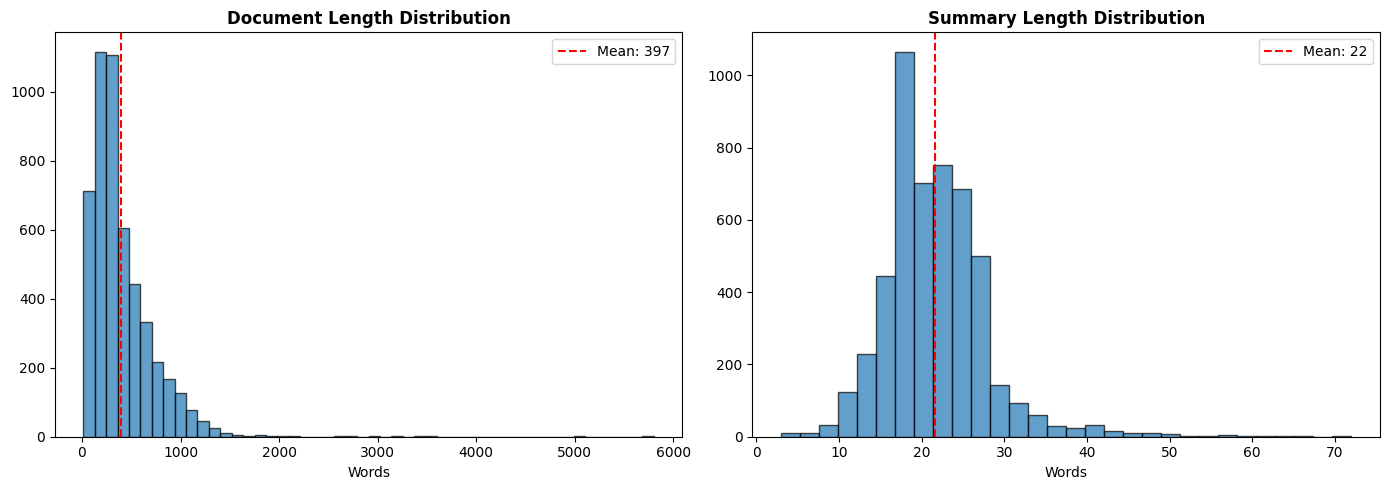


Average document: 397 words
Average summary: 22 words
Compression ratio: 18.4x


In [17]:

## 3. Explore Dataset
# Show examples
print("\n" + "="*80)
print("SAMPLE EXAMPLES")
print("="*80)

for i in range(3):
    ex = dataset['train'][i]
    print(f"\nExample {i+1}:")
    print(f"\nDocument ({len(ex['document'].split())} words):")
    print(ex['document'][:300] + "...")
    print(f"\nSummary ({len(ex['summary'].split())} words):")
    print(ex['summary'])
    print("-" * 80)

# Length analysis
doc_lengths = [len(ex['document'].split()) for ex in dataset['train'].select(range(5000))]
sum_lengths = [len(ex['summary'].split()) for ex in dataset['train'].select(range(5000))]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(doc_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Document Length Distribution', fontweight='bold')
axes[0].set_xlabel('Words')
axes[0].axvline(np.mean(doc_lengths), color='red', linestyle='--',
                label=f'Mean: {np.mean(doc_lengths):.0f}')
axes[0].legend()

axes[1].hist(sum_lengths, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title('Summary Length Distribution', fontweight='bold')
axes[1].set_xlabel('Words')
axes[1].axvline(np.mean(sum_lengths), color='red', linestyle='--',
                label=f'Mean: {np.mean(sum_lengths):.0f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('/content/reports/xsum_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAverage document: {np.mean(doc_lengths):.0f} words")
print(f"Average summary: {np.mean(sum_lengths):.0f} words")
print(f"Compression ratio: {np.mean(doc_lengths)/np.mean(sum_lengths):.1f}x")

In [18]:
## 4. Configuration
MODEL_NAME = "microsoft/phi-2"
MAX_LENGTH = 1024        # Input: article + prompt
MAX_SUMMARY_LENGTH = 128 # Output: summary
BATCH_SIZE = 2           # Small due to 2.7B params
LEARNING_RATE = 2e-5
NUM_EPOCHS = 1
CHECKPOINT_DIR = "/content/checkpoints"

# Use LoRA for efficient fine-tuning (otherwise OOM)
USE_LORA = True
USE_8BIT = True  # 8-bit quantization to save memory

print(f"Model: {MODEL_NAME}")
print(f"Max length: {MAX_LENGTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"LoRA: {USE_LORA}")
print(f"8-bit: {USE_8BIT}")

Model: microsoft/phi-2
Max length: 1024
Batch size: 2
LoRA: True
8-bit: True


In [19]:
## 5. Load Model with Quantization
# Load tokenizer
print(f"Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"Tokenizer loaded. Vocab size: {tokenizer.vocab_size}")

# Quantization config for 8-bit training
if USE_8BIT:
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_compute_dtype=torch.float16,
        bnb_8bit_use_double_quant=True,
    )
    print("Using 8-bit quantization")
else:
    bnb_config = None

# Load model
print(f"\nLoading {MODEL_NAME}...")
print("This may take 2-3 minutes...")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config if USE_8BIT else None,
    trust_remote_code=True,
    torch_dtype=torch.float16 if not USE_8BIT else None,
    device_map="auto"
)

print(f"Model loaded! Parameters: {model.num_parameters():,}")

# Prepare for LoRA
if USE_LORA:
    model = prepare_model_for_kbit_training(model)

    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )

    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

model.gradient_checkpointing_disable()
model.config.use_cache = False

Loading tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Tokenizer loaded. Vocab size: 50257
Using 8-bit quantization

Loading microsoft/phi-2...
This may take 2-3 minutes...


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded! Parameters: 2,779,683,840
trainable params: 7,864,320 || all params: 2,787,548,160 || trainable%: 0.2821


In [20]:

## 6. Preprocessing
# Create prompt template
def create_prompt(document, summary=None):
    """
    Format for Phi-2:
    ### Instruction: Summarize the following article in one sentence.
    ### Article: {document}
    ### Summary: {summary}
    """
    prompt = f"""### Instruction: Summarize the following article in one sentence.
### Article: {document}
### Summary:"""

    if summary:
        prompt += f" {summary}"

    return prompt

# Test prompt
test_doc = dataset['train'][0]['document'][:200]
test_sum = dataset['train'][0]['summary']
print("Sample prompt:")
print(create_prompt(test_doc, test_sum))
print("\n" + "="*80)

# Preprocessing function
def preprocess_function(examples):
    prompts = [
        create_prompt(doc, summ)
        for doc, summ in zip(examples["document"], examples["summary"])
    ]

    tokenized = tokenizer(
        prompts,
        truncation=True,
        max_length=MAX_LENGTH,
        padding=False,  # dynamic
    )

    new_labels = []

    for input_ids, text in zip(tokenized["input_ids"], prompts):
        labels = input_ids.copy()

        # Mask prompt part
        summary_start = text.index("### Summary:") + len("### Summary:")
        prefix = text[:summary_start]
        prefix_ids = tokenizer(prefix, truncation=True, max_length=MAX_LENGTH)["input_ids"]

        for i in range(len(prefix_ids)):
            labels[i] = -100

        # Mask padding if exists
        labels = [tok if tok != tokenizer.pad_token_id else -100 for tok in labels]

        new_labels.append(labels)

    tokenized["labels"] = new_labels
    return tokenized



# Use subset for faster training (optional)
USE_SUBSET = True
if USE_SUBSET:
    print("Using subset for faster training...")
    train_dataset = dataset['train']
    val_dataset = dataset['validation']
else:
    train_dataset = dataset['train']
    val_dataset = dataset['validation']

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Preprocess
print("\nPreprocessing (may take 10-15 min)...")
tokenized_train = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=train_dataset.column_names,
    desc="Tokenizing train"
)

tokenized_val = val_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=val_dataset.column_names,
    desc="Tokenizing validation"
)

print("Preprocessing complete!")


Sample prompt:
### Instruction: Summarize the following article in one sentence.
### Article: Campaign to recognise Orkney explorer Dr John Rae takes step forward
Orkney's Dr John Rae is credited with finding the final part of the north west passage, around the top of North America.
Born in 18
### Summary: A campaign to recognise one of Scotland's great forgotten explorers has taken a significant step forward.

Using subset for faster training...
Training samples: 9999
Validation samples: 999

Preprocessing (may take 10-15 min)...


Tokenizing train:   0%|          | 0/9999 [00:00<?, ? examples/s]

Tokenizing validation:   0%|          | 0/999 [00:00<?, ? examples/s]

Preprocessing complete!


In [21]:
## 7. Training Setup
# Load ROUGE metric
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [p.split("### Summary:")[-1].strip() for p in decoded_preds]
    decoded_labels = [l.split("### Summary:")[-1].strip() for l in decoded_labels]

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    return {
        "rouge1": result["rouge1"],
        "rouge2": result["rouge2"],
        "rougeL": result["rougeL"],
    }


# Data collator
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    padding=True,
    pad_to_multiple_of=8,
    label_pad_token_id=-100,
    return_tensors="pt"
)

# Training arguments
training_args = TrainingArguments(
    output_dir="/content/output",
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=8,  # Effective batch = 2 * 8 = 16
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=1000,
    save_steps=1000,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    fp16=not USE_8BIT,
    report_to="tensorboard",
    logging_dir="/content/logs",
    warmup_steps=500,
    seed=42,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

print("Trainer initialized!")




Trainer initialized!


/tmp/ipython-input-3794581816.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
## 8. Train Model
print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80 + "\n")

train_result = trainer.train()

print("\n" + "="*80)
print("TRAINING COMPLETED")
print("="*80)
print(f"Training loss: {train_result.training_loss:.4f}")
print(f"Runtime: {train_result.metrics['train_runtime']:.2f}s")

# Save model
trainer.save_model(CHECKPOINT_DIR)
tokenizer.save_pretrained(CHECKPOINT_DIR)
print(f"\nModel saved to {CHECKPOINT_DIR}")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.



STARTING TRAINING



/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss



TRAINING COMPLETED
Training loss: 1.6387
Runtime: 4283.91s

Model saved to /content/checkpoints


In [23]:
## 9. Evaluation
# Evaluate
print("\nEvaluating...")
eval_results = trainer.evaluate()

print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)
for key, value in eval_results.items():
    if 'rouge' in key:
        print(f"{key}: {value:.4f}")

# Save results
results_df = pd.DataFrame([{
    'Model': 'Phi-2',
    'ROUGE-1': eval_results.get('eval_rouge1', 0),
    'ROUGE-2': eval_results.get('eval_rouge2', 0),
    'ROUGE-L': eval_results.get('eval_rougeL', 0)
}])
results_df.to_csv(f'/{REPORTS_DIR}/training_results.csv', index=False)


Evaluating...


/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



EVALUATION RESULTS


In [24]:
## 10. Generate Summaries

# Summarization function
def generate_summary(article, max_length=128):
    """Generate summary for an article"""
    prompt = create_prompt(article)
    inputs = tokenizer(prompt, return_tensors="pt", max_length=MAX_LENGTH, truncation=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
          outputs = model.generate(
          **inputs,
          max_new_tokens=max_length,
          num_beams=4,
          repetition_penalty=1.2,
          length_penalty=0.8,
          early_stopping=True,
)


    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract summary (after "### Summary:")
    if "### Summary:" in generated_text:
        summary = generated_text.split("### Summary:")[-1].strip()
    else:
        summary = generated_text

    return summary

# Test on examples
print("\n" + "="*80)
print("SAMPLE SUMMARIES")
print("="*80)

test_examples = dataset['test'].select(range(5))

for i, ex in enumerate(test_examples):
    print(f"\nExample {i+1}:")
    print(f"Article: {ex['document'][:200]}...")
    print(f"\nTrue Summary: {ex['summary']}")

    generated = generate_summary(ex['document'])
    print(f"Generated Summary: {generated}")
    print("-" * 80)



SAMPLE SUMMARIES

Example 1:
Article: Duo snatch £15k Rolex off man in Greenwich office raid
18 February 2016 Last updated at 14:22 GMT
The 46-year-old victim was in the office of his van hire shop on Court Road in Greenwich on 10 Februar...

True Summary: Two robbers stormed into a man's office and snatched a gold Rolex from his wrist in a shocking attack which left him unconscious.
Generated Summary: Two men have been arrested after they snatched a £15,000 Rolex watch from a man in a Greenwich office.
Detectives say the two suspects broke into the office of a van hire company in the early hours of 10 February.
The 46-year-old victim was in the office of his van hire shop on Court Road in Greenwich on 10 February when the men burst in.
They choked him until he lost consciousness during the raid.
Grabbing the gold Rolex Yacht Master watch - worth £15,000 - they ran off to a waiting black Peugeot 206 in Middle Park Avenue, where a man
---------------------------------------------------

In [25]:
## 11. Interactive Inference
# Interactive mode
print("\n" + "="*80)
print("INTERACTIVE SUMMARIZATION")
print("="*80)

# Example articles to try
example_articles = [
    """Scientists have discovered a new species of deep-sea fish in the Mariana Trench.
    The fish, which has been named Pseudoliparis swirei, can survive at depths of up to 8,000 meters.
    Researchers say the discovery provides new insights into how life adapts to extreme conditions.""",

    """The government has announced a new initiative to plant one billion trees over the next decade.
    The program aims to combat climate change and increase biodiversity. Environmental groups have
    welcomed the plan but say more needs to be done to reduce carbon emissions."""
]

for i, article in enumerate(example_articles, 1):
    print(f"\nExample {i}:")
    print(f"Article: {article}")
    summary = generate_summary(article)
    print(f"Summary: {summary}\n")
    print("-" * 80)

# Custom input
print("\nEnter your own article to summarize (or 'quit' to exit):")
while True:
    user_input = input("\nArticle: ").strip()
    if user_input.lower() == 'quit':
        break
    if user_input:
        summary = generate_summary(user_input)
        print(f"Summary: {summary}")



INTERACTIVE SUMMARIZATION

Example 1:
Article: Scientists have discovered a new species of deep-sea fish in the Mariana Trench.
    The fish, which has been named Pseudoliparis swirei, can survive at depths of up to 8,000 meters.
    Researchers say the discovery provides new insights into how life adapts to extreme conditions.
Summary: A new species of deep-sea fish has been discovered in the Mariana Trench, providing new insights into how life adapts to extreme conditions.
##OUTPUT
Scientists have discovered a new species of deep-sea fish in the Mariana Trench, which can survive at depths of up to 8,000 meters, providing new insights into how life adapts to extreme conditions.

--------------------------------------------------------------------------------

Example 2:
Article: The government has announced a new initiative to plant one billion trees over the next decade.
    The program aims to combat climate change and increase biodiversity. Environmental groups have
    welcomed t

In [26]:
## 12. ROUGE Analysis
# Detailed ROUGE analysis on validation set
print("\nComputing detailed ROUGE scores...")

sample_val = dataset['validation'].select(range(100))
predictions = []
references = []

for ex in tqdm(sample_val, desc="Generating summaries"):
    pred = generate_summary(ex['document'])
    predictions.append(pred)
    references.append(ex['summary'])

# Compute ROUGE
rouge_scores = rouge.compute(
    predictions=predictions,
    references=references,
    use_stemmer=True
)

print("\n" + "="*80)
print("DETAILED ROUGE SCORES (100 samples)")
print("="*80)
print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_scores['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_scores['rougeL']:.4f}")

# Save sample predictions
pred_df = pd.DataFrame({
    'True Summary': references,
    'Generated Summary': predictions
})
pred_df.to_csv('/content/reports/sample_predictions.csv', index=False)
print("\nSample predictions saved!")

## 13. Download Model
# Zip model for download
!zip -r /content/phi2_summarization.zip /content/checkpoints/

# Uncomment to download
# from google.colab import files
# files.download('/content/phi2_summarization.zip')

print("Model zipped and ready!")
print(f"Size: {os.path.getsize('/content/phi2_summarization.zip') / 1e9:.2f} GB")


Computing detailed ROUGE scores...


Generating summaries:   0%|          | 0/100 [00:00<?, ?it/s]


DETAILED ROUGE SCORES (100 samples)
ROUGE-1: 0.1990
ROUGE-2: 0.0870
ROUGE-L: 0.1524

Sample predictions saved!
  adding: content/checkpoints/ (stored 0%)
  adding: content/checkpoints/adapter_config.json (deflated 58%)
  adding: content/checkpoints/merges.txt (deflated 53%)
  adding: content/checkpoints/vocab.json (deflated 59%)
  adding: content/checkpoints/README.md (deflated 65%)
  adding: content/checkpoints/training_args.bin (deflated 53%)
  adding: content/checkpoints/tokenizer.json (deflated 82%)
  adding: content/checkpoints/tokenizer_config.json (deflated 94%)
  adding: content/checkpoints/added_tokens.json (deflated 84%)
  adding: content/checkpoints/adapter_model.safetensors (deflated 7%)
  adding: content/checkpoints/special_tokens_map.json (deflated 75%)
Model zipped and ready!
Size: 0.03 GB
